# 2D Magnetic Dipole Lattice

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

We start by generating a 2D lattice of magnetic dipoles with a fixed magnetic moment.
The directions $\theta$ of the magnetic dipoles are sampled from a uniform distribution from $0$ to $2\pi$. The angular frequencies $\omega$ with which they rotate are sampled from a normal distribution with a mean value of 0. The standard deviation of the normal distribution is determined by the temperature of the system. 
We choose the scale of the temperature such that $T=\mathbb{E}[\omega^2]$. Since the expected value of a squared random variable following a normal distribution with mean 0 is its variance, we obtain a system with temperature $T$ by choosing the standard deviation of the normal distribution to be $\sqrt{T}$.

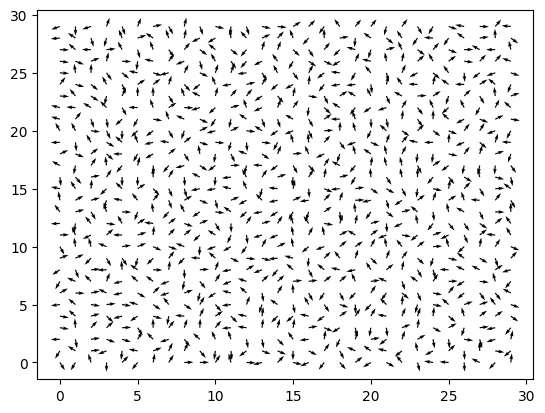

In [2]:
def generate_lattice(n=30, temperature=1.0):
    """
    Generate a 2D lattice of magnets.

    Parameters
    ----------
    n : int
        The number of lattice points in each dimension.
    temperature : float
        The temperature of the lattice.
    """

    theta = np.random.rand(n, n) * 2 * np.pi
    omega = np.random.randn(n, n) * np.sqrt(temperature)

    return theta, omega

theta, omega = generate_lattice()
plt.quiver(np.cos(theta), np.sin(theta));

To visualize the behavior of the lattice, we compute the local magnetization at each point by convolving the lattice with a constant, normalized 5x5 kernel. The colors of the arrows represent the angle of the local magnetization. The length of the arrows is proportional to the magnitude of the local magnetization.

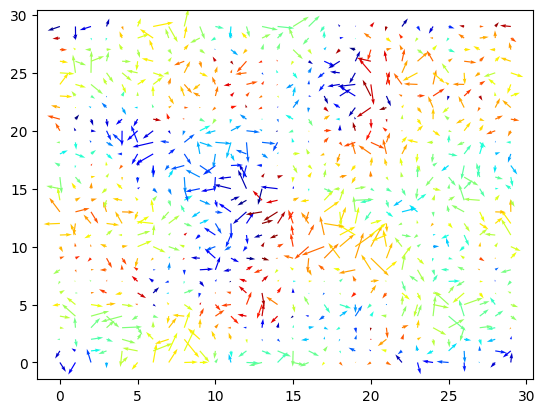

In [3]:
def compute_local_magnetization(theta, kernel_size=5):
    """
    Compute the local magnetization of a 2D lattice of magnets.

    Parameters
    ----------
    theta : array_like
        The angles of the magnets.
    kernel_size : int
        The size of the kernel to use for the local average.
    """

    kernel = np.ones((kernel_size, kernel_size)) / kernel_size**2
    x = np.cos(theta)
    y = np.sin(theta)
    local_average_x = convolve(x, kernel, mode='wrap')
    local_average_y = convolve(y, kernel, mode='wrap')

    magnetization_angle = np.arctan2(local_average_y, local_average_x)
    magnetization_magnitude = np.sqrt(local_average_x**2 + local_average_y**2)

    return magnetization_angle, magnetization_magnitude

magnetization_angle, magnetization_magnitude = compute_local_magnetization(theta)
plt.quiver(np.cos(theta) * magnetization_magnitude, np.sin(theta) * magnetization_magnitude, magnetization_angle, cmap='jet');

We now simulate the structure of the lattice for one time step $dt$. Each dipole interacts only with its nearest neighbors, at the edges of the lattice we use periodic boundary conditions. 
The interaction potential between two dipoles is proportional to the dot product of their magnetic moments, so the generalized force acting on each $\theta$ is proportional to $\sin(\theta_{neighbors} - \theta)$. The strength of the interaction is given by the constant $\alpha$.
If an external magnetic field is present, the strength of the interaction with the field is determined by $\beta$.

To keep the temperature of the system constant, we use a Nosé thermostat, which acts as an additional force term similar to friction. The thermostat term is proportional to the difference between the kinetic energy of the system and the desired temperature times the angular frequency of the dipoles, such that when the kinetic energy is higher than the desired temperature, the thermostat term acts as a force that slows down the dipoles, and when the kinetic energy is lower than the desired temperature, the thermostat term acts as a force that accelerates the dipoles. The strength of the thermostat is given by the constant $\gamma$.

We then use Verlet integration to update the directions and angular frequencies of the dipoles according to the total force. In Verlet integration, the angular frequencies are updated first and then the directions are updated with the updated frequencies. $\theta$ is then returned to the interval $[0, 2\pi]$ using a modulo operation.

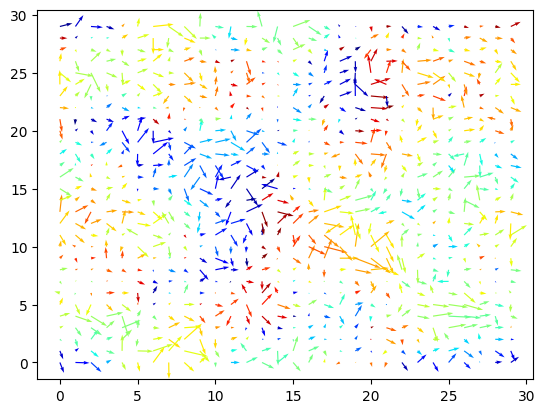

In [4]:
def update_lattice(theta, omega, field=None, target_temp=1.0, alpha=1, beta=0, gamma=1, dt=0.1):
    """
    Update the state of the lattice using the Nose-Hoover thermostat.

    Parameters
    ----------
    theta : array_like
        The angles of the magnets.
    omega : array_like
        The angular velocities of the magnets.
    field : tuple of array_like, optional
        The external magnetic field.
    target_temp : float
        The target temperature of the thermostat.
    alpha : float
        The strength of the interaction between magnets.
    beta :  float
        The strength of the interaction with the external field.
    gamma : float
        The strength of the thermostat.
    dt : float
        The time step.
    """

    # Force from neighbours with periodic boundary conditions

    theta_up = np.roll(theta, 1, axis=0)
    theta_down = np.roll(theta, -1, axis=0)
    theta_left = np.roll(theta, 1, axis=1)
    theta_right = np.roll(theta, -1, axis=1)

    x_neighbours = np.cos(theta_up) + np.cos(theta_down) + np.cos(theta_left) + np.cos(theta_right)
    y_neighbours = np.sin(theta_up) + np.sin(theta_down) + np.sin(theta_left) + np.sin(theta_right)

    theta_neighbours = np.arctan2(y_neighbours, x_neighbours)
    force = alpha * np.sin(theta_neighbours - theta)

    # Force from external field

    if field is not None:
        field_x, field_y = field
        field_angle = np.arctan2(field_y, field_x)
        field_mag = np.sqrt(field_x**2 + field_y**2)
        force += beta * np.sin(field_angle - theta) * field_mag

    # Nose thermostat

    avg_temp = np.mean(omega**2)
    thermostat = gamma * (target_temp - avg_temp) * omega

    # Verlet integration

    omega += (force + thermostat) * dt
    theta += omega * dt

    # Angle back to [0, 2pi]

    theta = np.mod(theta, 2 * np.pi)

    return theta, omega

theta, omega = update_lattice(omega, theta)
plt.quiver(np.cos(theta) * magnetization_magnitude, np.sin(theta) * magnetization_magnitude, magnetization_angle, cmap='jet');

We can now simulate the behavior of the lattice for a number of time steps and visualize the results. In the simulation below we vary the temperature of the system. For low temperatures, the dipoles align with each other and the emergence of magnetic domains can be observed. For high temperatures, the dipoles are randomly oriented and the magnetization is close to zero.

Step: 0, Temperature 1.03


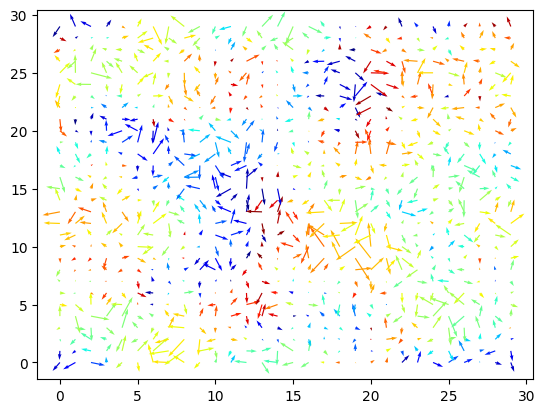

Step: 500, Temperature 0.06


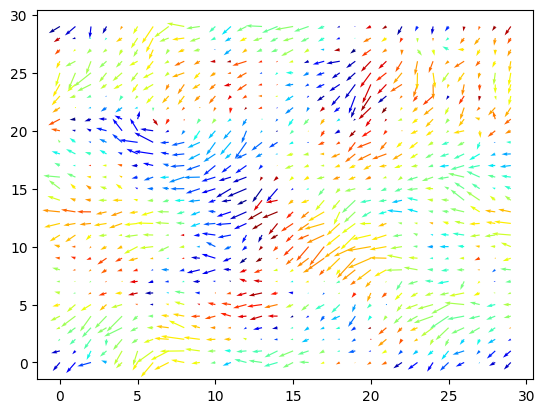

Step: 999, Temperature 1.00


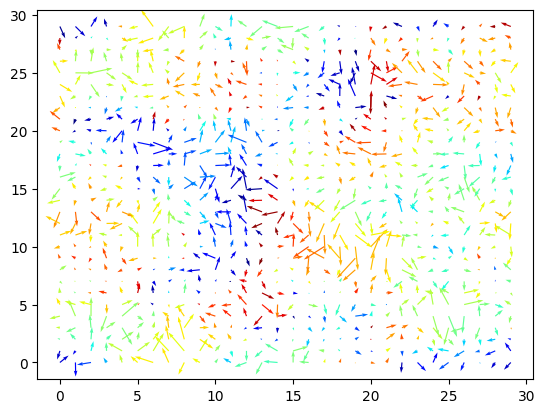

In [5]:
n_steps = 1000

target_temperatures = np.concatenate((np.linspace(1, 0, n_steps//3), np.zeros(n_steps//3), np.linspace(0, 1, n_steps - 2*(n_steps//3))))

theta, omega = generate_lattice()
temperatures = []
for step, target_temp in enumerate(target_temperatures):
    theta, omega = update_lattice(theta, omega, target_temp=target_temp)
    temperatures.append(np.mean(omega**2))

    if step in [0, n_steps//2, n_steps-1]:
        print(f"Step: {step}, Temperature {temperatures[-1]:.2f}")
        plt.quiver(np.cos(theta) * magnetization_magnitude, np.sin(theta) * magnetization_magnitude, magnetization_angle, cmap='jet')
        plt.show()

We can also plot the temperature of the system and the target temperature over time to see how the thermostat works.

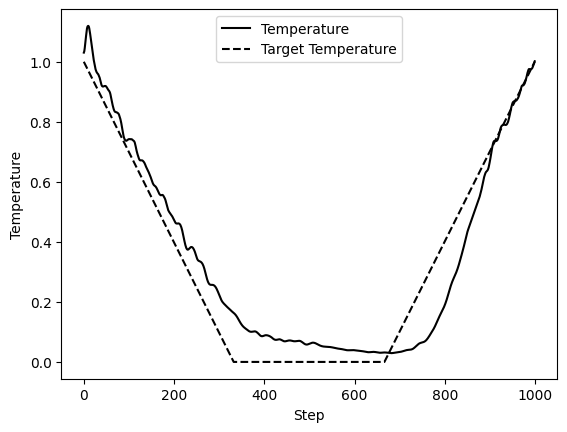

In [6]:
plt.plot(temperatures, label='Temperature', color='black')
plt.plot(target_temperatures, label='Target Temperature', linestyle='--', color='black')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Temperature')
plt.show()

Next we simulate the behavior of the lattice for different temperatures and calculate the total magnetization of the lattice at each temperature. To reduce the variance of the total magnetization, we simulate the lattice for a number of time steps for each temperature and then calculate the average magnetization over the last time steps.
When plotting the total magnetization over the temperature, a phase transition can be observed.

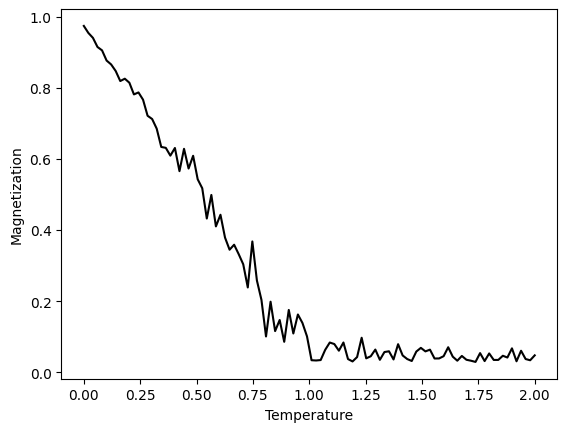

In [7]:
n_temps = 100
steps_per_temp = 200
target_temperatures = np.linspace(2, 0, n_temps)

theta, omega = generate_lattice()
total_magnetization = []
for target_temp in target_temperatures:
    average_magnetization = []
    for step in range(steps_per_temp):
        theta, omega = update_lattice(theta, omega, target_temp=target_temp)
        if step > 3 * steps_per_temp // 4:
            average_magnetization.append(np.sqrt(np.mean(np.cos(theta))**2 + np.mean(np.sin(theta))**2))
    total_magnetization.append(np.mean(average_magnetization))

plt.plot(target_temperatures, total_magnetization, color='black')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.show()

Now we will apply an external magnetic field to the lattice. 

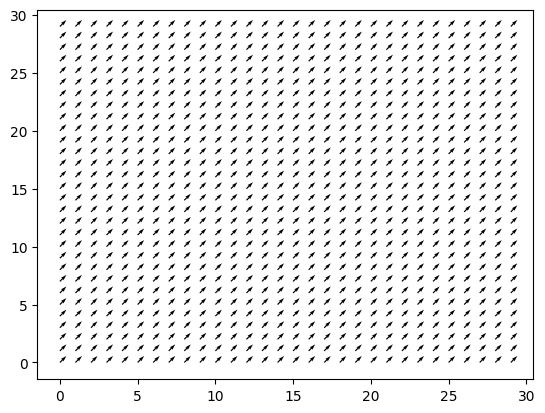

In [8]:
magnetic_field = (np.ones(theta.shape), np.ones(theta.shape))

plt.quiver(magnetic_field[0], magnetic_field[1]);

We simulate the lattice with varying magnetic field strengths and calculate the total magnetization of the lattice at each magnetic field strength. We then plot the total magnetization over the magnetic field strength and observe a hysteresis loop.

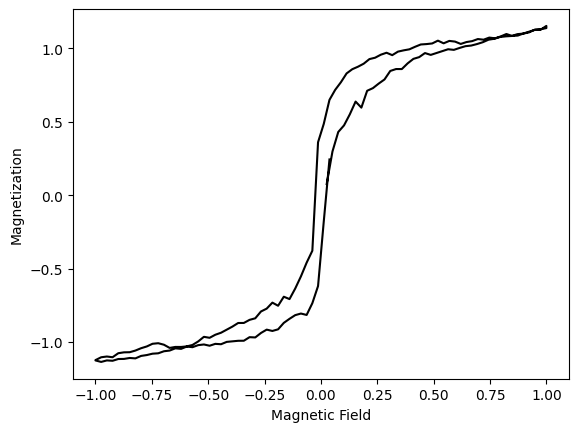

In [9]:
n_field_strengths = 200
steps_per_field_strength = 200
fied_strengths = np.concatenate((
    np.linspace(0, 1, n_field_strengths // 5), 
    np.linspace(1, -1, 2 * n_field_strengths // 5), 
    np.linspace(-1, 1, 2 * n_field_strengths // 5),
    ))

theta, omega = generate_lattice()
total_magnetization = []
for beta in fied_strengths:
    average_magnetization = []
    for step in range(steps_per_temp):
        theta, omega = update_lattice(theta, omega, field=magnetic_field, beta=beta)
        if step > 3 * steps_per_temp // 4:
            average_magnetization.append(np.mean(np.cos(theta)) + np.mean(np.sin(theta)))
    total_magnetization.append(np.mean(average_magnetization))

plt.plot(fied_strengths[1:162], total_magnetization[1:162], color='black')
plt.xlabel('Magnetic Field')
plt.ylabel('Magnetization')
plt.show()